In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import nltk
import pickle
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import torch.functional as F
from tqdm import tqdm
from scipy import sparse
from keras.utils import to_categorical
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#path = '/content/drive/MyDrive/DATAS/yamarket/data_21_good_text.csv'
n_categories = 3006

In [4]:
!gdown --id 1Ub6UuQQ9-1A5XXg600fxOXJdpizv3wup

Downloading...
From: https://drive.google.com/uc?id=1Ub6UuQQ9-1A5XXg600fxOXJdpizv3wup
To: /content/data_21_good_text.csv
304MB [00:01, 203MB/s]


In [133]:
path = '/content/data_21_good_text.csv'
data_rev = pd.read_csv(path)
del data_rev['Unnamed: 0']
del data_rev['Unnamed: 0.1']

In [134]:
brand_mean_price = data_rev[data_rev['price'] != 0].groupby('brand')['price'].agg(mean_price = 'mean')
data_rev = pd.merge(data_rev, brand_mean_price, on = 'brand', how = 'outer')
data_rev.loc[data_rev['price'] == 0, 'price'] = data_rev.loc[data_rev['price'] == 0, 'mean_price']
data_rev = data_rev.fillna(0)
data_rev.head()

,prod_id,price,brand,id,author,description,rate,date,mean_price
0,10692976.0,3085.57234,23.0,280,Konstantin Zeleznov,достоинств больш экра карт min быстродейств фу...,4,2014-03-04,3085.57234
1,10692976.0,3085.57234,23.0,281,Юлия Л.,достоинств очен плох угл обзор записыва плюс с...,5,2014-03-22,3085.57234
2,10692976.0,3085.57234,23.0,282,Имя скрыто,достоинств 5 дюймов экра android вход 2 отличн...,5,2014-05-18,3085.57234
3,10692976.0,3085.57234,23.0,283,роман п.,достоинств давольн неприхотлив модел удобн про...,5,2014-03-28,3085.57234
4,10692976.0,3085.57234,23.0,284,Александр Н.,достоинств экра 5 процессор справля ур флэш 32...,4,2014-02-24,3085.57234


In [135]:
small_data = pd.DataFrame()
for i in range(1, 6) :
  data = data_rev[data_rev['rate'] == i].iloc[:2000]
  small_data = pd.concat([small_data, data], axis = 0)
data_rev = small_data

In [136]:
data_rev.shape

(10000, 9)

In [137]:
data_rev.head()

,prod_id,price,brand,id,author,description,rate,date,mean_price
13,1.069298e+07,3085.57234,23.0,293,Юлия Ф.,достоинств экра недостатк плох качеств корпус ...,1,2015-03-20,3085.57234
28,1.710418e+09,3085.57234,23.0,7689,Дмитрий И.,достоинств хорош батаре держ очен долг будет н...,1,2018-07-13,3085.57234
43,1.710418e+09,3085.57234,23.0,7729,Kirill V.,достоинств прост излишеств недостатк по прост ...,1,2016-12-01,3085.57234
44,1.710418e+09,3085.57234,23.0,7731,Имя скрыто,достоинств красив кирпич вес размер ударопрочн...,1,2017-09-29,3085.57234
45,1.710418e+09,3085.57234,23.0,7733,Михель М.,достоинств батаре держ дольш обычн 2 ест возмо...,1,2017-02-04,3085.57234


In [ ]:

def normalize_text(text) :
  stop_words = set(stopwords.words("russian"))
  sentences = nltk.sent_tokenize(text)
  answer_list = []

  for sentence in sentences:
      words = nltk.word_tokenize(sentence)
      without_stop_words = [word.lower() for word in words if not word in stop_words and word.isalnum()]
      for el in without_stop_words:
       answer_list.append(nltk.stem.SnowballStemmer('russian').stem(el))
       #answer_list.append(el)

  return ' '.join(answer_list)

texts_for_df = []
for i in tqdm(data_rev['description'].values, position=0, leave=True) :
  texts_for_df.append(normalize_text(i))
  
data_rev.loc[:, 'description'] = texts_for_df

In [ ]:
#data_rev.to_csv('/content/drive/MyDrive/DATAS/yamarket/data_21_good_text.csv')

In [12]:
!pip install pymorphy2

     |████████████████████████████████| 61kB 7.8MB/s 
     |████████████████████████████████| 8.2MB 13.2MB/s 


In [14]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pymorphy2
from nltk.stem import WordNetLemmatizer 

from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [15]:
def data_prepare(language_dict, ru=False, en=False, es=False):

    if ru:
        stop_words = set(stopwords.words('russian'))
        lemmatizer = pymorphy2.MorphAnalyzer()
    elif en:
        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()
    elif es:
        stop_words = set(stopwords.words('spanish'))
        lemmatizer = nltk.stem.SnowballStemmer('spanish')
        
    dict_prepared = []
    
    for  text in tqdm(language_dict['description'].values):
        text = re.sub(r'[^\w\s]','', text.lower())
        text = re.sub(r'[0-9]','', text)
        
        word_tokens = word_tokenize(text)
        word_tokens = [w for w in word_tokens if not w in stop_words]
        if ru:
            word_tokens = [lemmatizer.parse(w)[0].normal_form for w in word_tokens]
        elif en:
            word_tokens = [lemmatizer.lemmatize(w) for w in word_tokens]
        elif es:
            word_tokens = [lemmatizer.stem(w) for w in word_tokens]
        
        word_tokens = [w for w in word_tokens if not w in stop_words]
        
        filtered_text = ' '.join(word_tokens)
        dict_prepared.append( filtered_text)
    return dict_prepared

In [16]:
ru_prepared = data_prepare(data_rev, ru=True)

100%|██████████| 10000/10000 [03:07<00:00, 53.42it/s]


In [138]:
len(ru_prepared)

10000

In [ ]:
ru_prepared[0]

'достоинство экр недостатк плохой качество корпус пол год окантовк начесть осыпат отремонтиров реальна продажа'

In [75]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('seaborn')
plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels

from collections import Counter

In [ ]:
words = []
for text in tqdm(ru_prepared):
    words.extend(word_tokenize(text))

100%|██████████| 5000/5000 [00:02<00:00, 2222.56it/s]


In [ ]:
count_words = Counter(words)
sorted_words = sorted(count_words.items(), key=lambda count_words: count_words[1], reverse=True)
print(len(sorted_words))

16945


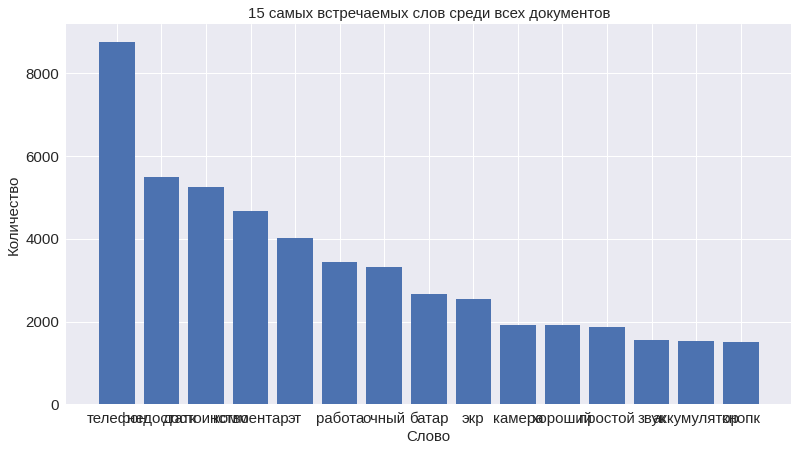

In [ ]:
plt.figure(figsize=(13, 7))
plt.bar(range(15), [sorted_words[i][1] for i in range(15)])
plt.xticks(range(15), [sorted_words[i][0] for i in range(15)])
plt.title('15 самых встречаемых слов среди всех документов')
plt.xlabel('Слово')
plt.ylabel('Количество');
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
y = data_rev['rate'].values

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(ru_prepared)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(4000, 16902) (1000, 16902) (4000,) (1000,)


In [ ]:
clf = LogisticRegression(penalty='l1', C=50 , verbose = 10 , solver='liblinear')


clf.fit(X_train , y_train )

[LibLinear]

LogisticRegression(C=50, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001,
                   verbose=10, warm_start=False)

In [ ]:
predict = clf.predict(X_test)
print('accuraccy ', accuracy_score(y_test, predict.astype(int)))
print('mae ', np.abs((predict - y_test)).mean())

accuraccy  0.388


In [ ]:
predict.mean()

3.035

In [ ]:
predict.std()

1.449060040163968

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
sc = StandardScaler()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegressionCV, LinearRegression , LassoCV
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from sklearn.metrics.scorer import make_scorer
from sklearn.svm import LinearSVC, SVC


In [ ]:
model = LassoCV(cv = 3 , n_jobs= - 1,alphas = np.linspace(1,100000,100), verbose = True)
model.fit(X_train, y_train)
predict = model.predict(X_test)
predict[predict > 5] = 5
predict[predict < 0] = 0
print('accuraccy ', accuracy_score(y_test, predict.astype(int)))
print('mae ', np.abs((predict - y_test)).mean())

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
.....................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   54.6s finished


accuraccy  0.192
mae  1.217372


###BOW


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data_rev.loc[:]['description'].values)

In [ ]:
X.shape

(314193, 177904)

In [ ]:
data_rev.loc[:]['price'].values.reshape(-1, 1).shape

(314193, 1)

In [ ]:
data_rev['brand'] = data_rev['brand'] % 3007
X = sparse.hstack((X, data_rev.loc[:]['price'].values.reshape(-1, 1)))
X = sparse.hstack((X, to_categorical(data_rev.loc[:]['brand'].values - 1, num_classes = n_categories)))

In [ ]:
y = data_rev['rate'].values

In [ ]:
print(X.shape)
print(y.shape)

(314193, 180911)
(314193,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(251354, 180911) (62839, 180911) (251354,) (62839,)


In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)
predict = model.predict(X_test)
accuracy_score(y_test, predict)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.5035885357819189

###TF IDF vectorize

In [108]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegressionCV, LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from sklearn.metrics.scorer import make_scorer
from sklearn.svm import LinearSVC, SVC


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [109]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(data_rev.loc[:]['description'].values)

In [110]:
X.shape

(10000, 27750)

In [111]:
data_rev['brand'] = data_rev['brand'] % 3007
X = sparse.hstack((X, data_rev['price'].values.reshape(-1, 1)))
X = sparse.hstack((X, to_categorical(data_rev['brand'].values - 1, num_classes = n_categories)))

In [112]:
y = data_rev['rate'].values

In [113]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 30757) (2000, 30757) (8000,) (2000,)


In [115]:
model = LinearRegression()
model.fit(X_train, y_train)
predict = model.predict(X_test)
predict[predict > 5] = 5
predict[predict < 0] = 0
print('accuraccy ', accuracy_score(y_test, predict.astype(int)))
print('mae ', np.abs((predict - y_test)).mean())

accuraccy  0.2595
mae  1.0248298451345785


In [ ]:
saveModel(model)

TypeError: ignored

In [116]:
from sklearn.multiclass import OneVsRestClassifier
clf = SVC(verbose = 1)
clf = OneVsRestClassifier(clf, n_jobs = -1).fit(X_train, y_train)

In [117]:
pred = clf.predict(X_test)
accuracy_score(pred, y_test)

0.1755

In [118]:
pred.mean()

2.1225

###Full Connection


In [ ]:
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchtext import data
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.model_selection import train_test_split

from IPython.display import clear_output

In [ ]:
def torchFromSparse(X, y) :
  values = X.data
  indices = np.vstack((X.row, X.col))

  i = torch.LongTensor(indices)
  v = torch.FloatTensor(values)
  shape = X.shape

  X_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))
  y_tensor = torch.FloatTensor(y)
  return X_tensor, y_tensor

In [ ]:
class FC_net(nn.Module):
    def __init__(self, in_features, dropout):
        
        super().__init__()
  
        self.fc1 = nn.Linear(in_features, 10000)
        self.Re = torch.nn.ReLU()
        self.fc2 = nn.Linear(10000, 500)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(500, 1)
    def forward(self, x):
        x = self.fc1(x)
        x = self.Re(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.Re(x)
        x = self.dropout(x)
        x = self.out(x)
        return x

In [ ]:
X_train, y_train = torchFromSparse(sparse.coo_matrix(X_train), y_train)
X_test, y_test = torchFromSparse(sparse.coo_matrix(X_test), y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([4000, 22355]) torch.Size([1000, 22355]) torch.Size([4000]) torch.Size([1000])


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
batch_size = 128
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=True)

In [ ]:
def train_FC(model, iterator):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in tqdm(iterator, position=0, leave=True) :
        input, label = batch

        input = input.to(device)
        label = label.to(device)

        #print(text.device, text_lengths.device, label.device)
        optimizer.zero_grad()
        predictions = model(input).squeeze(1).to(device)
        loss = criterion(predictions, label)
        #print(predictions.device, label.device)
        acc = accuracy_score(predictions.cpu().detach().numpy().astype(int), label.cpu().numpy())

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_fc = FC_net(X.shape[1], 0.2).to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model_fc.parameters(), lr=0.001)

In [ ]:
import time
for epoch in range(100) :
  x = train_FC(model_fc, train_dataloader)
  valid_acc = 0
  for input, label in test_dataloader :
        input = input.to(device)
        label = label.to(device)
        predictions = model_fc(input).squeeze(1).to(device)
        acc = accuracy_score(predictions.cpu().detach().numpy().astype(int), label.cpu().numpy())
        valid_acc += acc.item()
  print('loss {}, accuracy {}, val_accuracy {}'.format(x[0], x[1], valid_acc / len(test_dataloader)))
  time.sleep(0.5)

# embedings

In [18]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import spacy
#import jovian
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import string
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error

In [19]:
from itertools import chain
from collections import Counter
from operator import itemgetter

d = {}
for  i in range(len(ru_prepared)):
  ru_prepared[i] = ru_prepared[i].split()

In [20]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [21]:
ru_prepared[0]

['достоинство',
 'экр',
 'недостатк',
 'плохой',
 'качество',
 'корпус',
 'пол',
 'год',
 'окантовк',
 'начесть',
 'осыпат',
 'отремонтиров',
 'реальна',
 'продажа']

In [23]:
from collections import defaultdict


unique = set()

for l in ru_prepared:
    unique = unique.union(set(l))
result = defaultdict(lambda: 0)
for element in unique:
    for l in ru_prepared:
        result[element] += (element == l[0])

In [24]:
print("num_words before:",len(result.keys()))

num_words before: 23958


In [25]:
result['экр']

0

In [26]:
for i in ru_prepared:
  for  j in i:
    result[j] += 1

In [27]:
print("num_words before:",len(result.keys()))
for word in list(result):
    if result[word] < 2:
        del result[word]
print("num_words after:",len(result.keys()))

num_words before: 23958
num_words after: 12490


In [28]:
print("num_words before:",len(result.keys()))
for word in list(result):
    if result[word] > 5000:
        del result[word]
print("num_words after:",len(result.keys()))

num_words before: 12490
num_words after: 12482


In [29]:
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in result:
    vocab2index[word] = len(words)
    words.append(word)

In [30]:
def encode_sentence(text, vocab2index, N=100):
    #tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in text])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [31]:
reviews = pd.DataFrame()
reviews['encoded'] = pd.Series(ru_prepared).apply(lambda x: np.array(encode_sentence(x,vocab2index )))
reviews.head()

,encoded
0,"[[1, 1, 1, 4582, 9488, 4959, 3603, 2730, 41, 7..."
1,"[[1, 6051, 2751, 5353, 1, 7104, 9520, 4845, 1,..."
2,"[[1, 9846, 11104, 1, 9846, 11302, 1, 5708, 103..."
3,"[[1, 93, 4703, 11954, 2397, 10097, 6051, 2716,..."
4,"[[1, 2751, 5353, 332, 9405, 1583, 6746, 6657, ..."


In [32]:
X = list(reviews['encoded'])

y = list(data_rev['rate'].map({1:0,2:1,3:2,4:3,5:4}))
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [34]:
class ReviewsDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [164]:
def Mae(y_pred, y) :
  y_pred = torch.argmax(y_pred, 1)
  #print(y_pred[:5], y[:5])
  mae = torch.sum(torch.abs(y_pred - y).type(torch.FloatTensor))
  return mae

In [35]:
train_ds = ReviewsDataset(X_train, y_train)
valid_ds = ReviewsDataset(X_valid, y_valid)

In [145]:
def train_model(model, epochs=10, lr=0.001, path_to_save = None, step_size = 150, gamma = 0.1):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = step_size, gamma=gamma)
    history = []
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        scheduler.step()
        for x, y, l in train_dl:
            x = x.long()
            y = y.long()
            y_pred = model(x, l)
            optimizer.zero_grad()
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        
        val_loss, val_acc, val_rmse, val_mae = validation_metrics(model, val_dl)

        history.append((sum_loss/total, val_loss, val_acc, val_rmse, val_mae, get_lr(optimizer)))
        if i % 5 == 1:
            print("epoch %.0f train loss %.3f, val loss %.3f, val accuracy %.3f, and val rmse %.3f, val mae %.3f learning_rate %.6f" % (i, sum_loss/total, val_loss, val_acc, val_rmse, val_mae, get_lr(optimizer)))
            if (not path_to_save is None) :
              torch.save(model.state_dict(), path_to_save)
    return history

def validation_metrics (model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    sum_mae = 0.0
    for x, y, l in valid_dl:
        x = x.long()
        y = y.long()
        y_hat = model(x, l)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        sum_mae += Mae(y_hat, y)
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]
    model.train()
    return sum_loss/total, correct/total, sum_rmse/total, sum_mae / total

In [141]:
def plotHist(history) :
  name = ['train loss', 'val loss', 'val accuracy', 'val rmse', 'val_mae', 'learning_rate']
  history = np.array(history)
  for i in range(6) :
    plt.plot(history[:, i], label = name[i])
    plt.legend()
    plt.show()

In [142]:
batch_size = 5000
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

###fixed len Lstm

In [156]:
class LSTM_fixed_len(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 5)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [157]:
model_fixed =  LSTM_fixed_len(vocab_size, 50, 50)

In [165]:
hist = train_model(model_fixed, epochs=10, lr=0.01)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


epoch 1 train loss 1.508, val loss 1.639, val accuracy 0.202, and val rmse 2.349, val mae 1.899 learning_rate 0.010000
epoch 6 train loss 1.430, val loss 1.683, val accuracy 0.222, and val rmse 2.242, val mae 1.780 learning_rate 0.010000


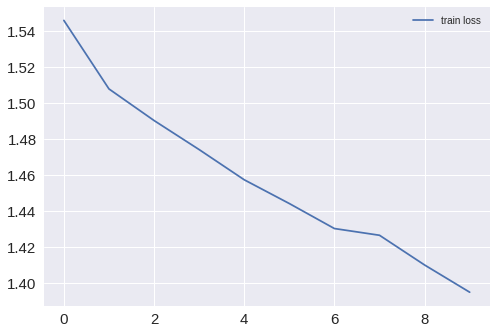

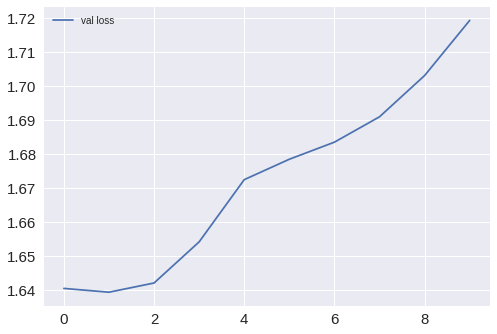

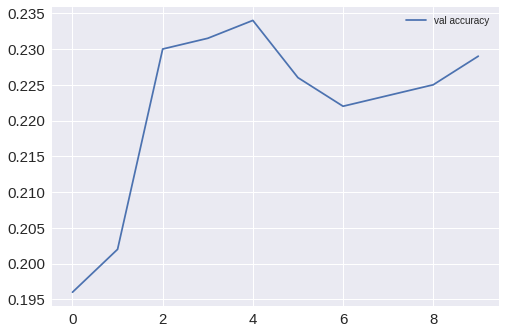

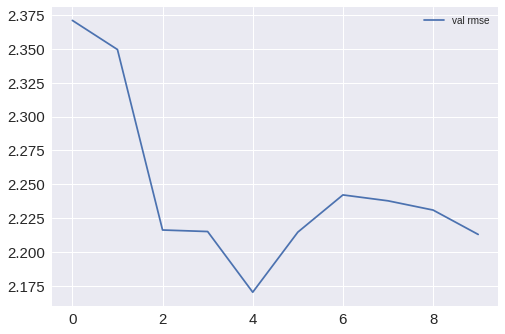

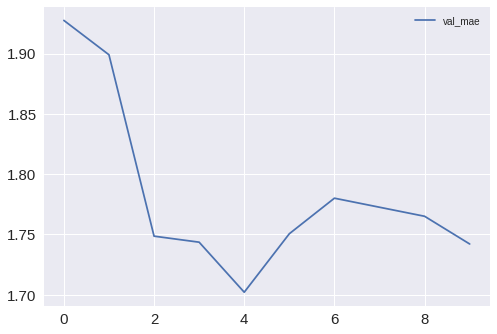

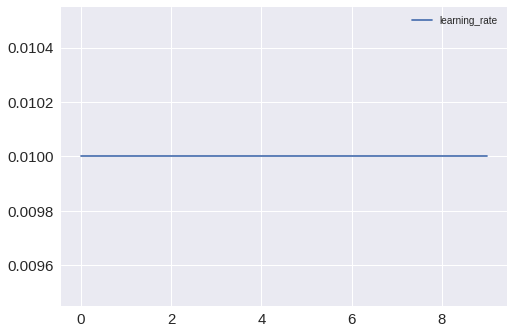

In [166]:
plotHist(hist)

###variable len lstm

In [54]:
class LSTM_variable_input(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(0.3)
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 5)
        
    def forward(self, x, s):
        x = self.embeddings(x)
        x = self.dropout(x)
        x_pack = pack_padded_sequence(x, s, batch_first=True, enforce_sorted=False)
        out_pack, (ht, ct) = self.lstm(x_pack)
        out = self.linear(ht[-1])
        return out

In [ ]:
model = LSTM_variable_input(vocab_size, 50, 50)

In [ ]:
hist = train_model(model, epochs=200, lr=0.005, step_size = 100, path_to_save = "/content/drive/MyDrive/DATAS/yamarket/lstm_dump") #lr = 0.005, epochs = 600, gamma = 0.1, step_size = 150

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


epoch 1 train loss 1.602, val loss 1.607, val accuracy 0.213, and val rmse 1.971, val mae 1.556 learning_rate 0.005000
epoch 6 train loss 1.551, val loss 1.573, val accuracy 0.260, and val rmse 1.814, val mae 1.378 learning_rate 0.005000
epoch 11 train loss 1.437, val loss 1.491, val accuracy 0.306, and val rmse 1.631, val mae 1.196 learning_rate 0.005000
epoch 16 train loss 1.301, val loss 1.512, val accuracy 0.328, and val rmse 1.554, val mae 1.121 learning_rate 0.005000
epoch 21 train loss 1.201, val loss 1.612, val accuracy 0.335, and val rmse 1.524, val mae 1.097 learning_rate 0.005000
epoch 26 train loss 1.110, val loss 1.543, val accuracy 0.362, and val rmse 1.395, val mae 0.982 learning_rate 0.005000
epoch 31 train loss 1.029, val loss 1.711, val accuracy 0.364, and val rmse 1.431, val mae 1.008 learning_rate 0.005000
epoch 36 train loss 0.954, val loss 1.697, val accuracy 0.382, and val rmse 1.357, val mae 0.940 learning_rate 0.005000
epoch 41 train loss 0.882, val loss 1.736,

In [ ]:
plotHist(hist)

###variable len lstm my variant

In [102]:
class LSTM_net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           bidirectional=True, 
                           batch_first = True,
                           dropout=0.2)
        
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.Re = torch.nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 5)
        
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        #print(hidden.size())
        #return(hidden)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        output = self.fc1(hidden)
        output = self.Re(output)
        output = self.fc2(output)
        #output = torch.nn.ReLU(output)
        output = self.dropout(output)
            
        return output

In [103]:
model = LSTM_net(vocab_size, 50, 50)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [104]:
hist = train_model(model, epochs=300, lr=0.005, step_size = 100, path_to_save = "/content/drive/MyDrive/DATAS/yamarket/Mylstm_dump") #lr = 0.005, epochs = 600, gamma = 0.1, step_size = 150

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


epoch 1 train loss 1.608, val loss 1.607, val accuracy 0.227, and val rmse 2.099, learning_rate 0.005000
epoch 6 train loss 1.520, val loss 1.529, val accuracy 0.293, and val rmse 1.743, learning_rate 0.005000
epoch 11 train loss 1.429, val loss 1.495, val accuracy 0.301, and val rmse 1.694, learning_rate 0.005000
epoch 16 train loss 1.288, val loss 1.436, val accuracy 0.338, and val rmse 1.436, learning_rate 0.005000
epoch 21 train loss 1.126, val loss 1.415, val accuracy 0.368, and val rmse 1.376, learning_rate 0.005000
epoch 26 train loss 0.964, val loss 1.481, val accuracy 0.378, and val rmse 1.270, learning_rate 0.005000
epoch 31 train loss 0.826, val loss 1.619, val accuracy 0.375, and val rmse 1.297, learning_rate 0.005000
epoch 36 train loss 0.642, val loss 1.839, val accuracy 0.376, and val rmse 1.232, learning_rate 0.005000
epoch 41 train loss 0.495, val loss 2.406, val accuracy 0.350, and val rmse 1.369, learning_rate 0.005000
epoch 46 train loss 0.405, val loss 2.528, val a

KeyboardInterrupt: ignored

In [ ]:
plotHist(hist)

###Convolution

In [105]:
class CNN_net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_filters = 64):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        Ks = [3, 5, 7]
        
        # three different convolutional layers
        self.convs = nn.ModuleList([nn.Conv1d(embedding_dim, num_filters, k) for k in Ks])
        self.dropout = nn.Dropout(0.2)  # a dropout layer
        self.fc1 = nn.Linear(3 * num_filters, 5)  # a dense layer for classification
        self.Re = torch.nn.ReLU()
    
    @staticmethod
    def conv_and_max_pool(x, conv):
        """Convolution and global max pooling layer"""
        return F.relu(conv(x).permute(0, 2, 1).max(1)[0])

    def forward(self, inputs, lenght):
        # Conv1d takes in (batch, channels, seq_len), but raw embedded is (batch, seq_len, channels)
        embedded = self.embedding(inputs).permute(0, 2, 1)
        x = [self.conv_and_max_pool(embedded, k) for k in self.convs]  # convolution and global max pooling
        x = self.fc1(self.dropout(torch.cat(x, 1)))  # concatenation and dropout

        return x

In [167]:
model = CNN_net(vocab_size, 50, 50)

In [168]:
hist = train_model(model, epochs=150, lr=0.005, step_size = 70)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


epoch 1 train loss 1.710, val loss 1.999, val accuracy 0.240, and val rmse 1.689, val mae 1.314 learning_rate 0.005000
epoch 6 train loss 1.424, val loss 1.626, val accuracy 0.292, and val rmse 1.483, val mae 1.112 learning_rate 0.005000
epoch 11 train loss 1.264, val loss 1.487, val accuracy 0.316, and val rmse 1.415, val mae 1.046 learning_rate 0.005000
epoch 16 train loss 1.105, val loss 1.422, val accuracy 0.347, and val rmse 1.333, val mae 0.968 learning_rate 0.005000
epoch 21 train loss 0.948, val loss 1.367, val accuracy 0.377, and val rmse 1.314, val mae 0.930 learning_rate 0.005000
epoch 26 train loss 0.798, val loss 1.359, val accuracy 0.390, and val rmse 1.266, val mae 0.890 learning_rate 0.005000
epoch 31 train loss 0.665, val loss 1.372, val accuracy 0.382, and val rmse 1.265, val mae 0.891 learning_rate 0.005000
epoch 36 train loss 0.537, val loss 1.399, val accuracy 0.379, and val rmse 1.253, val mae 0.885 learning_rate 0.005000
epoch 41 train loss 0.444, val loss 1.437,

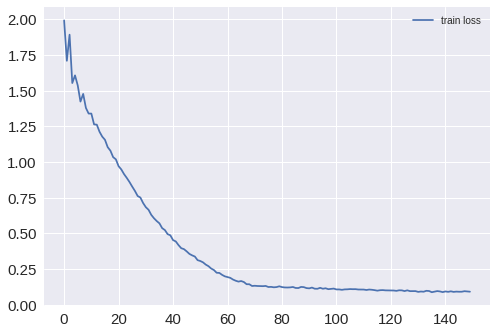

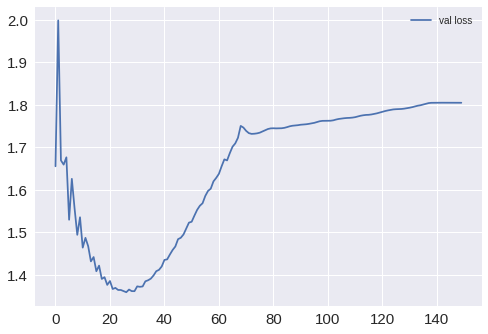

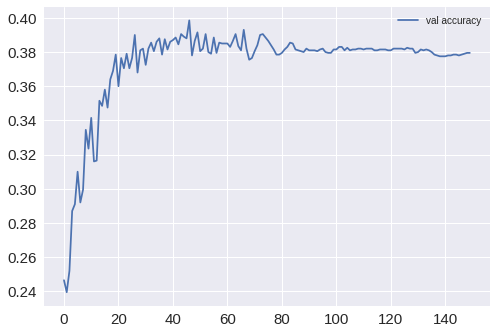

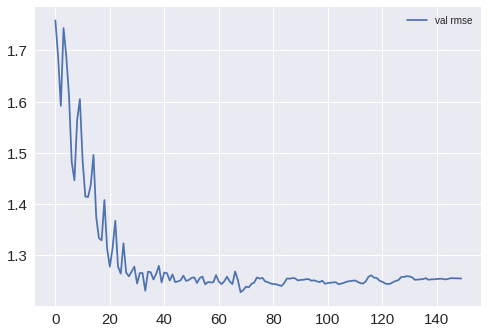

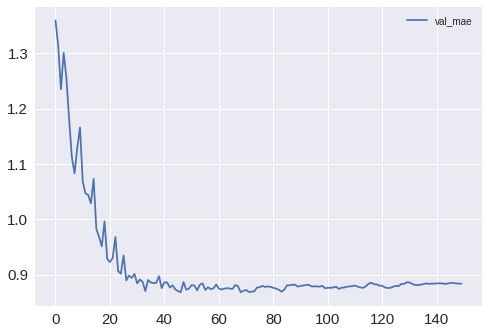

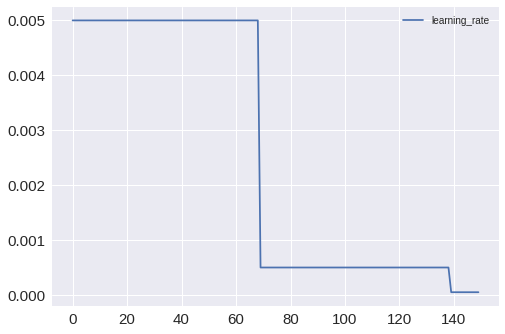

In [169]:
plotHist(hist)

###Kaggle variant

In [ ]:
SEED = 42

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(data_rev)

In [ ]:
class DataFrameDataset(data.Dataset):

    def __init__(self, df, fields, is_test=False, **kwargs):
        examples = []
        y = df['rate'].values
        x = df['description'].values
        for i in tqdm(range(len(y)), position=0, leave=True) :
          text = x[i]
          label = y[i]
          examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.description)

    @classmethod
    def splits(cls, fields, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)
        data_field = fields

        if train_df is not None:
            train_data = cls(train_df.copy(), data_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), data_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), data_field, True, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)

In [ ]:
TEXT = data.Field(tokenize = 'spacy', include_lengths = True)
LABEL = data.LabelField(dtype = torch.float)
fields = [('description',TEXT), ('rate',LABEL)]
train_ds, val_ds = DataFrameDataset.splits(fields, train_df = train_df, val_df = valid_df)

100%|██████████| 1250/1250 [00:00<00:00, 3871.61it/s]


In [ ]:
print(vars(train_ds[0]))
print(type(train_ds[0]))

{'description': ['достоинств', 'шустр', 'экра', 'показа', 'очен', 'переда', 'цвет', 'дела', 'классн', 'фотк', 'прост', 'супер', 'некотор', 'момет', 'зеральн', 'фотоаппарат', 'недостатк', 'слома', 'раз', 'наушник', 'втор', 'ден', 'эт', 'очен', 'важн', 'очен', 'огорч', 'техникик', 'разьем', 'лома', 'комментар', 'пок', 'ок', 'кром', 'разъем', 'наушник'], 'rate': 2}
<class 'torchtext.data.example.Example'>


In [ ]:
MAX_VOCAB_SIZE = 20000
LABEL.build_vocab(train_ds)
TEXT.build_vocab(train_ds, 
                 max_size = MAX_VOCAB_SIZE,
                 vectors = 'glove.6B.200d',
                 unk_init = torch.Tensor.zero_)

.vector_cache/glove.6B.zip: 862MB [06:51, 2.10MB/s]                           
100%|█████████▉| 399370/400000 [00:27<00:00, 13923.78it/s]

In [ ]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_ds, val_ds), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

In [ ]:
num_epochs = 30
learning_rate = 0.001

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 200
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.2

In [ ]:
class LSTM_net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.Re = torch.nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        #print(hidden.size())
        #return(hidden)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        output = self.fc1(hidden)
        output = self.Re(output)
        output = self.fc2(output)
        #output = torch.nn.ReLU(output)
        output = self.dropout(output)
            
        return output


In [ ]:
model = LSTM_net(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT)
model.to(device)

criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)
model.embedding.weight.data.copy_(pretrained_embeddings)

torch.Size([150930, 200])


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [ ]:
def evaluate(model, iterator):
    
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.description

            text = text.to(device)
            label = batch.rate.to(device)
            text_lengths = text_lengths.to('cpu')
            
            predictions = model(text, text_lengths).squeeze(1)
            acc = Mae(predictions, batch.rate)
            
            epoch_acc += acc.item()
        
    return epoch_acc / len(iterator)

In [ ]:
def train(model, iterator):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in  tqdm(iterator, position=0, leave=True) :
        text, text_lengths = batch.description

        text = text.to(device)
        label = batch.rate.to(device)
        text_lengths = text_lengths.to('cpu')

        #print(text.device, text_lengths.device, label.device)
        optimizer.zero_grad()
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.rate)
        acc = Mae(predictions, batch.rate)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time
t = time.time()
loss=[]
acc=[]
val_acc=[]

for epoch in range(0, 2 * num_epochs):
    
    train_loss, train_acc = train(model, train_iterator)
    valid_acc = evaluate(model, valid_iterator)
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train MAE: {train_acc:.2f}')
    print(f'\t Val. MAE: {valid_acc:.2f} | Epoch {epoch}')
    
    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)
    torch.save(model.state_dict(), "/content/drive/MyDrive/DATAS/yamarket/lstm_dump")

print(f'time:{time.time()-t:.3f}')

100%|██████████| 1841/1841 [04:58<00:00,  6.16it/s]


	Train Loss: 0.556 | Train MAE: 0.26
	 Val. MAE: 0.58 | Epoch 0


100%|██████████| 1841/1841 [04:59<00:00,  6.16it/s]


	Train Loss: 0.556 | Train MAE: 0.26
	 Val. MAE: 0.58 | Epoch 1


100%|██████████| 1841/1841 [04:58<00:00,  6.17it/s]


	Train Loss: 0.554 | Train MAE: 0.26
	 Val. MAE: 0.57 | Epoch 2


100%|██████████| 1841/1841 [04:58<00:00,  6.18it/s]


	Train Loss: 0.551 | Train MAE: 0.26
	 Val. MAE: 0.57 | Epoch 3


100%|██████████| 1841/1841 [04:57<00:00,  6.18it/s]


	Train Loss: 0.544 | Train MAE: 0.25
	 Val. MAE: 0.58 | Epoch 4


100%|██████████| 1841/1841 [04:57<00:00,  6.18it/s]


	Train Loss: 0.552 | Train MAE: 0.25
	 Val. MAE: 0.58 | Epoch 5


100%|██████████| 1841/1841 [04:57<00:00,  6.18it/s]


	Train Loss: 0.557 | Train MAE: 0.25
	 Val. MAE: 0.57 | Epoch 6


100%|██████████| 1841/1841 [04:58<00:00,  6.18it/s]


	Train Loss: 0.551 | Train MAE: 0.25
	 Val. MAE: 0.57 | Epoch 7


100%|██████████| 1841/1841 [04:57<00:00,  6.18it/s]


	Train Loss: 0.545 | Train MAE: 0.25
	 Val. MAE: 0.58 | Epoch 8


100%|██████████| 1841/1841 [04:58<00:00,  6.17it/s]


	Train Loss: 0.550 | Train MAE: 0.25
	 Val. MAE: 0.58 | Epoch 9


 50%|█████     | 927/1841 [02:30<01:48,  8.46it/s]